# Explore here

Cargamos librerias y CSV

In [19]:
#Importamos librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
df = pd.read_csv("/workspaces/machine-learning-vicentepolo/data/raw/medical_insurance_cost.csv", sep= ',' )

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Análisis de constantes. Recordamos que si tienen valores de 1 son candidatos a ser eliminados. 

In [20]:
n_unicos = df.nunique()
n_unicos

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

Revisión de duplicados

In [21]:
duplicadas = df[df.duplicated(keep=False)]

duplicadas

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


Procedemos a eliminar los duplicados

In [22]:
df.drop(df[df.duplicated()].index, inplace=True)

Realizamos una segunda comprobación

In [23]:
df.duplicated().sum()

np.int64(0)

Comprobamos valores faltantes

<Axes: >

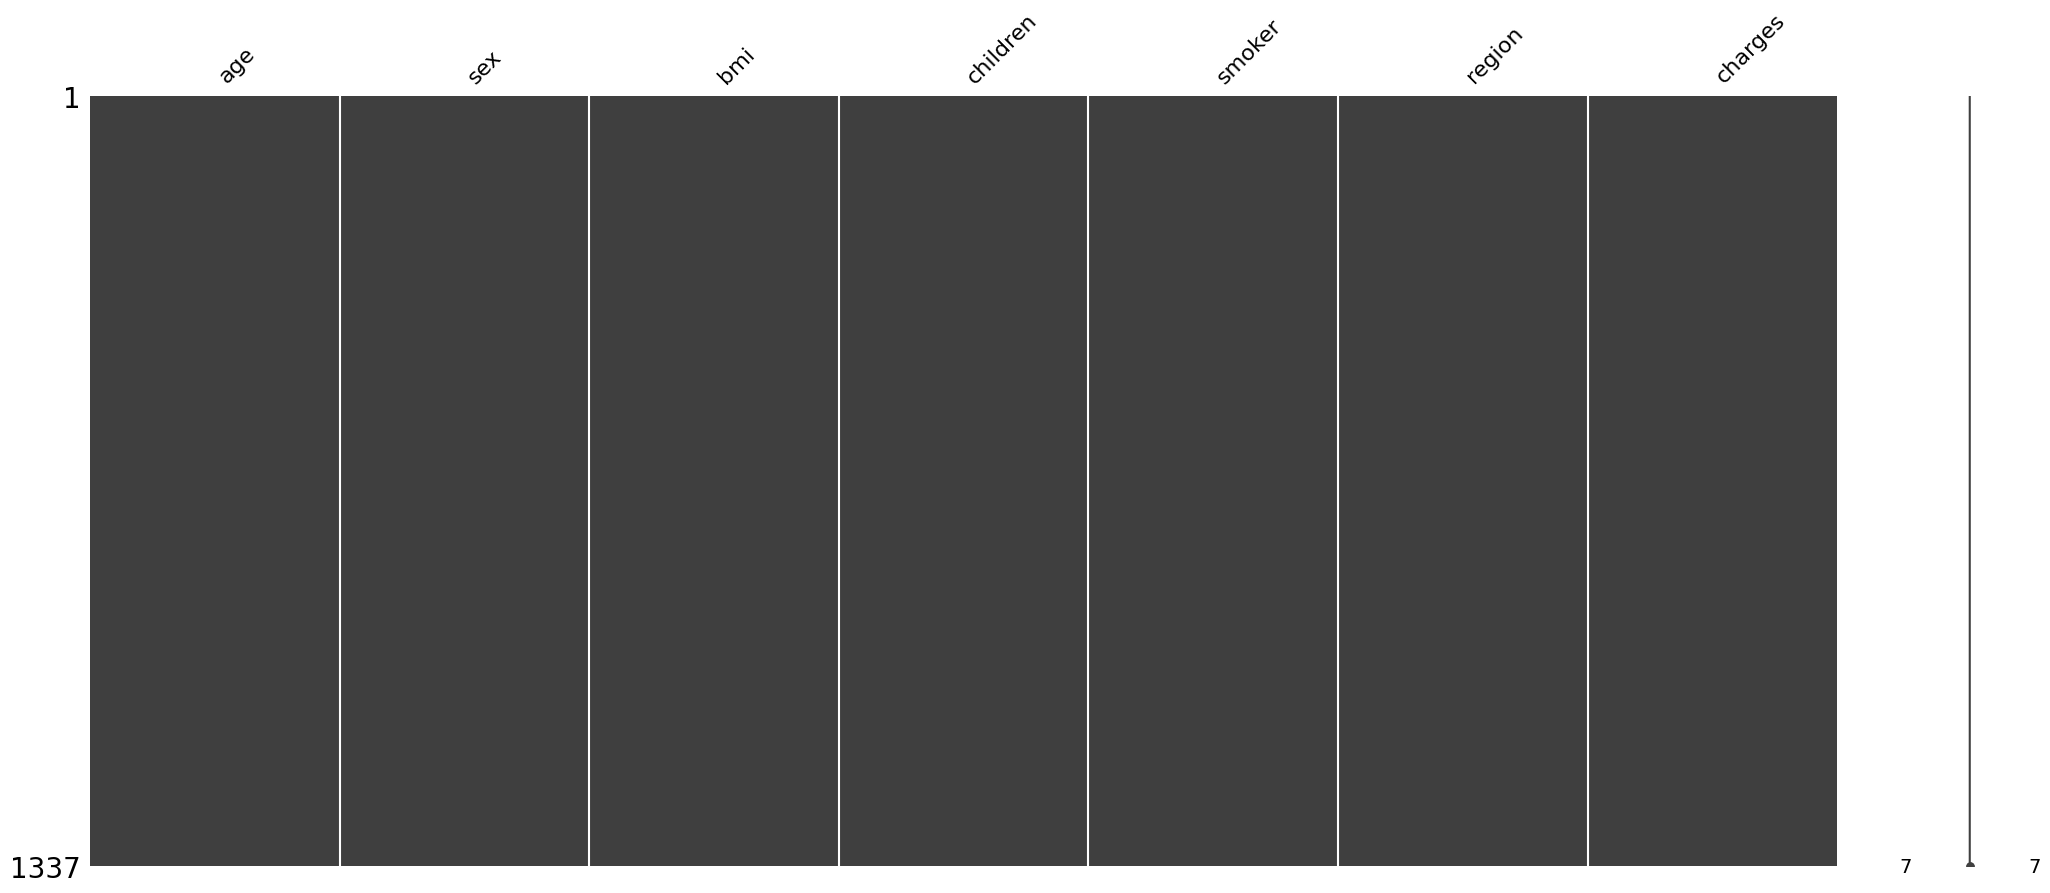

In [24]:
msno.matrix(df)

In [25]:
df.isnull().mean()*100

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

Comprobación de columnas categóricas 

In [26]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Se entiende que charges va a ser la variable independiente. Hay que transformar el resto de valores de tipo object a numéricos

In [27]:
df["sex_n"] = pd.factorize(df["sex"])[0]
df["smoker_n"] = pd.factorize(df["smoker"])[0]
df["region_n"] = pd.factorize(df["region"])[0]

In [28]:
df.head()

,age,sex,bmi,children,smoker,region,charges,sex_n,smoker_n,region_n
0,19,female,27.900,0,yes,southwest,16884.92400,0,0,0
1,18,male,33.770,1,no,southeast,1725.55230,1,1,1
2,28,male,33.000,3,no,southeast,4449.46200,1,1,1
3,33,male,22.705,0,no,northwest,21984.47061,1,1,2
4,32,male,28.880,0,no,northwest,3866.85520,1,1,2


Comprobamos que efectivamente la conversión e introducción de las nuevas columnas ha sido llevada a cabo

In [29]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
sex_n         int64
smoker_n      int64
region_n      int64
dtype: object

Escalamos y aprovechamos para seleccionar las nuevas columnas para su estudio

In [30]:

num_variables = ["age", "bmi", "children","sex_n", "smoker_n", "region_n", "charges"]

scaler = MinMaxScaler()
scal_features = scaler.fit_transform(df[num_variables])
df_scal = pd.DataFrame(scal_features, index = df.index, columns = num_variables)
df_scal.head()

,age,bmi,children,sex_n,smoker_n,region_n,charges
0,0.021739,0.321227,0.0,0.0,0.0,0.000000,0.251611
1,0.000000,0.479150,0.2,1.0,1.0,0.333333,0.009636
2,0.217391,0.458434,0.6,1.0,1.0,0.333333,0.053115
3,0.326087,0.181464,0.0,1.0,1.0,0.666667,0.333010
4,0.304348,0.347592,0.0,1.0,1.0,0.666667,0.043816


# Procedemos a asignar valores a X e Y

In [31]:

X = df.drop(['charges','sex','smoker','region'], axis=1)
y = df['charges']

In [34]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split

X = df_scal.drop("charges", axis = 1)
y = df_scal["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

selection_model = SelectKBest(f_regression, k = 4)
selection_model.fit(X_train, y_train)

selected_columns = X_train.columns[selection_model.get_support()]
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = selected_columns)
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = selected_columns)

X_train_sel.head()

,age,bmi,children,smoker_n
0,0.108696,0.230024,0.0,1.0
1,0.065217,0.263250,0.4,1.0
2,0.739130,0.580172,0.4,1.0
3,0.978261,0.686306,0.0,1.0
4,0.630435,0.286252,0.4,1.0


He de guardarlos en CSV porque si no por defecto me lo guarda como series

In [36]:
X_train_sel["charges"] = y_train.values
X_test_sel["charges"] = y_test.values
X_train_sel.to_csv("../data/processed/clean_train.csv", index = False)
X_test_sel.to_csv("../data/processed/clean_test.csv", index = False)

In [37]:
train_data = pd.read_csv("../data/processed/clean_train.csv")
test_data = pd.read_csv("../data/processed/clean_test.csv")

train_data.head()

,age,bmi,children,smoker_n,charges
0,0.108696,0.230024,0.0,1.0,0.020339
1,0.065217,0.263250,0.4,1.0,0.034446
2,0.739130,0.580172,0.4,1.0,0.516374
3,0.978261,0.686306,0.0,1.0,0.196070
4,0.630435,0.286252,0.4,1.0,0.137177


In [38]:

selection_model = SelectKBest(f_regression, k = 4)
selection_model.fit(X_train, y_train)

selected_columns = X_train.columns[selection_model.get_support()]
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = selected_columns)
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = selected_columns)

X_train_sel.head()

,age,bmi,children,smoker_n
0,0.108696,0.230024,0.0,1.0
1,0.065217,0.263250,0.4,1.0
2,0.739130,0.580172,0.4,1.0
3,0.978261,0.686306,0.0,1.0
4,0.630435,0.286252,0.4,1.0


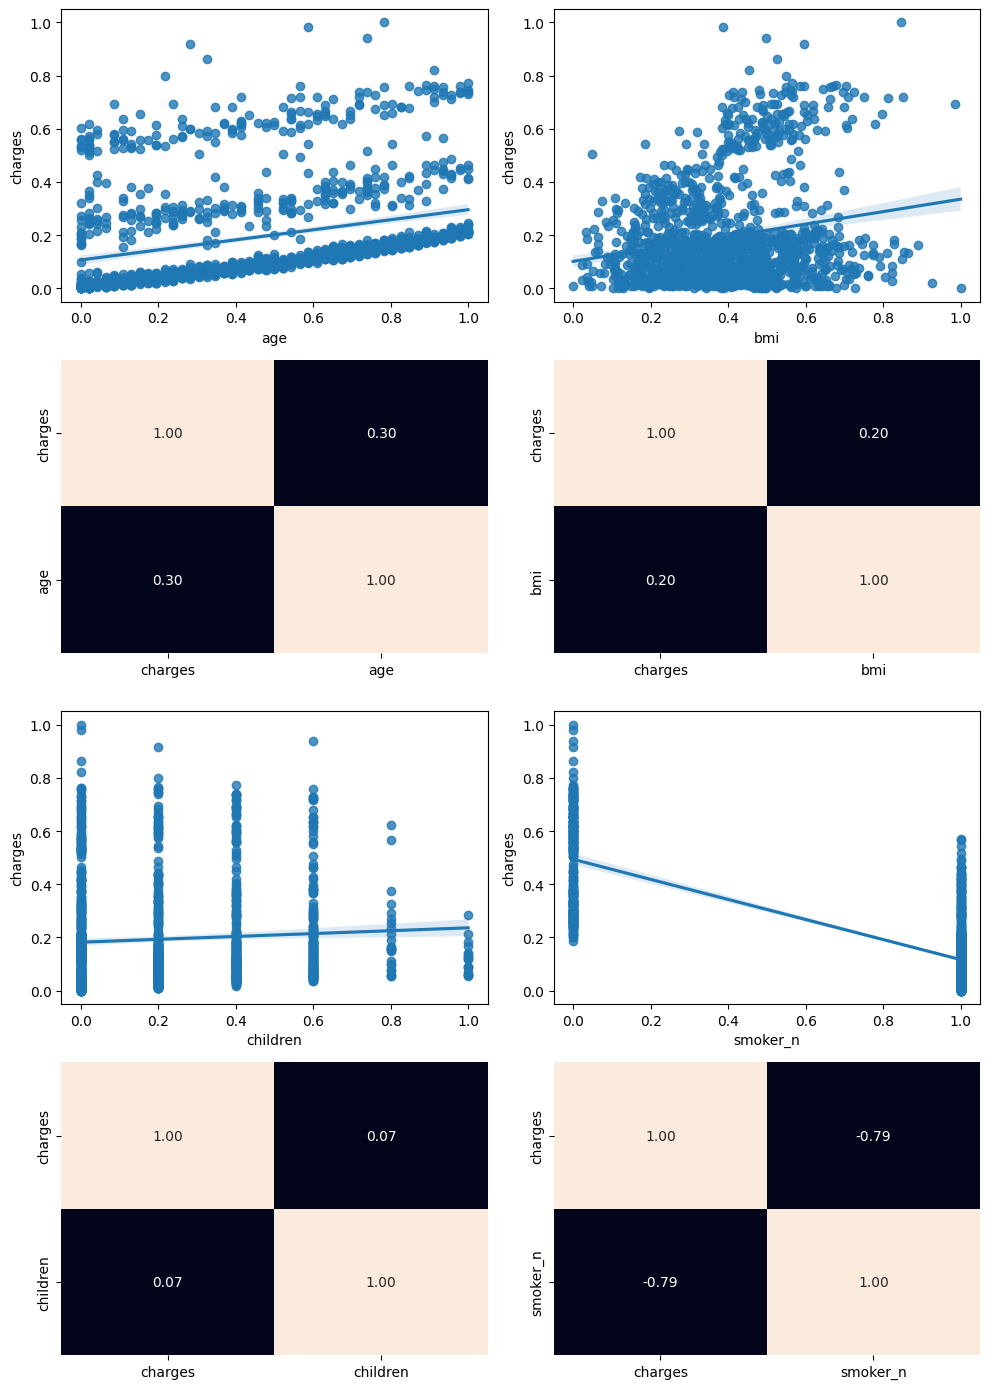

In [39]:
fig, axis = plt.subplots(4, 2, figsize = (10, 14))
df = pd.concat([train_data, test_data])

sns.regplot(data = df, x = "age", y = "charges", ax = axis[0, 0])
sns.heatmap(df[["charges", "age"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)

sns.regplot(data = df, x = "bmi", y = "charges", ax = axis[0, 1])
sns.heatmap(df[["charges", "bmi"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1], cbar = False)

sns.regplot(data = df, x = "children", y = "charges", ax = axis[2, 0])
sns.heatmap(df[["charges", "children"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 0], cbar = False)

sns.regplot(data = df, x = "smoker_n", y = "charges", ax = axis[2, 1])
sns.heatmap(df[["charges", "smoker_n"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 1], cbar = False)

plt.tight_layout()
plt.show()

Ajustamos a un modelo de regresion lineal

In [40]:

X = sm.add_constant(X)  
# Ajustar el modelo a los datos
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     667.0
Date:                Tue, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                        11:54:55   Log-Likelihood:                 1229.0
No. Observations:                1337   AIC:                            -2444.
Df Residuals:                    1330   BIC:                            -2408.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3154      0.011     28.856      0.0

Dado el valor de R-squared podemos determinar que el modelo explica el 75.1% de la variabilidad en la variable dependiente (charges), por lo que es un señal de que ajusta bien los datos.

F-statistic nos muestra que el modelo es significativo para predecir charges. 

En los coeficientes destacan:

- Cuanto mas años se tiene, mayor el recargo
- A mayor indice de masa corporal, mas se paga. 
- Por cada hijo adicional, mayor el cargo
- Los fumadores tienen cargos muy significativos

- El sexo no tiene un valor significativo en los cargos


Procedemos a eliminar la columna sex

In [41]:
X = X.drop(columns=['sex_n'])

Exploramos la relación entre fumar y el bmi, fruto del anterior análisis que considera interesante.

In [42]:
X['smoker_bmi'] = X['smoker_n'] * X['bmi']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     1166.
Date:                Tue, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                        11:55:02   Log-Likelihood:                 1526.7
No. Observations:                1337   AIC:                            -3039.
Df Residuals:                    1330   BIC:                            -3003.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0452      0.013      3.484      0.0

Conclusiones: 

R-Squared ahora es de 84%, frente al 75% anterior, esto significa que se consigue una información mas relevante.

Que el BIC presente un valor menor también nos indica que el modelo explica mejor los datos.

Respecto a la relación bmi-fumadores: A medida que aumenta el índice de masa corporal (bmi), el efecto positivo de smoker sobre charges disminuye.

En ambos análisis, el Omnibus muestra una fuerte desviación de la normalidad en los residuos.



In [43]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [44]:

print("Intercepto (a)")
# Coeficientes con nombres de variables
coef_dict = {
    'age': model.coef_[0],
    'bmi': model.coef_[1],
    'children': model.coef_[2],
    'smoker_n': model.coef_[3],
    'region_n': model.coef_[4],
    'smoker_bmi': model.coef_[5]
}

for variable, coef in coef_dict.items():
    print(f"{variable}: {coef}")



print("--------------------------------------------------------------------\n")

print("Coeficientes (b)")
# Coeficientes con nombres de variables
coef_dict = {
    'age': model.coef_[0],
    'bmi': model.coef_[1],
    'children': model.coef_[2],
    'smoker_n': model.coef_[3],
    'region_n': model.coef_[4],
    'smoker_bmi': model.coef_[5]
}

for variable, coef in coef_dict.items():
    print(f"{variable}: {coef}")

Intercepto (a)
age: 0.18265620721883224
bmi: 0.18547400424952565
children: 0.04262834826191039
smoker_n: -0.0015913438958955334
region_n: -0.3679598528523667
smoker_bmi: 0.011378960816903455
--------------------------------------------------------------------

Coeficientes (b)
age: 0.18265620721883224
bmi: 0.18547400424952565
children: 0.04262834826191039
smoker_n: -0.0015913438958955334
region_n: -0.3679598528523667
smoker_bmi: 0.011378960816903455


Confirmamos todos los puntos indicados anteriormente: 

En los coeficientes destacan:

- Cuanto mas años se tiene, mayor el recargo
- A mayor indice de masa corporal, mas se paga. 
- Por cada hijo adicional, mayor el cargo
- Los fumadores tienen cargos muy significativos

El coeficiente de smoker_n (si es fumador o no) tiene un valor extremadamente alto

In [45]:
y_pred = model.predict(X_test)
y_pred

array([ 0.11107321,  0.07136633,  0.21159985,  0.4885978 ,  0.12827883,
        0.1953619 ,  0.4650671 ,  0.00298129,  0.15527176,  0.16366977,
        0.14941043,  0.51132843,  0.47551792,  0.25614271,  0.15186728,
        0.13172488,  0.04538604,  0.49164921,  0.0313305 ,  0.06949194,
        0.0422447 ,  0.46343277,  0.22275094,  0.46533839,  0.47824218,
        0.07020344,  0.55138865,  0.56265373,  0.16243162,  0.20662249,
        0.0838539 ,  0.18861147, -0.00706463,  0.17280237,  0.61711555,
        0.17605964,  0.05515378,  0.04620457,  0.47927158,  0.1293109 ,
        0.09172841,  0.46152601,  0.54033827,  0.17636648,  0.1012115 ,
        0.03429084,  0.07821545,  0.12283684,  0.05107612,  0.12985632,
        0.09106233,  0.17186162,  0.47907249,  0.04230001,  0.1552407 ,
        0.14147695,  0.1536126 ,  0.02209835,  0.48248129,  0.13285859,
        0.23376452,  0.11636993,  0.18381706,  0.0059923 ,  0.24947555,
        0.15176155,  0.1484482 ,  0.47020092,  0.37440304,  0.24

In [46]:
from sklearn.metrics import mean_squared_error, r2_score

print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

Mean squared error: 0.00904319426153682
Coefficient of determination: 0.8068466322629112


In [52]:
# Crear el modelo de regresión lineal
X = sm.add_constant(X)
model = sm.OLS(y, X)

# Ajustar el modelo a los datos
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     1166.
Date:                Tue, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                        12:01:01   Log-Likelihood:                 1526.7
No. Observations:                1337   AIC:                            -3039.
Df Residuals:                    1330   BIC:                            -3003.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0452      0.013      3.484      0.0

In [53]:
residuos = results.resid

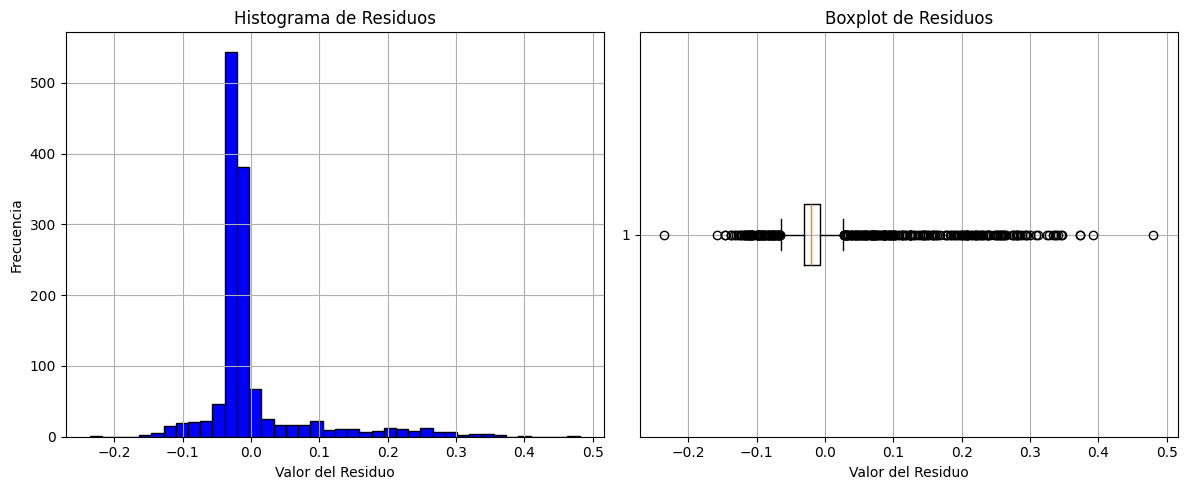

In [54]:
# Crea una figura con dos subgráficos (uno para el histograma y otro para el boxplot)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histograma de los residuos en el primer subgráfico (ax1)
ax1.hist(residuos, bins=40, color='blue', edgecolor='black')
ax1.set_title('Histograma de Residuos')
ax1.set_xlabel('Valor del Residuo')
ax1.set_ylabel('Frecuencia')
ax1.grid(True)

# Boxplot de los residuos en el segundo subgráfico (ax2)
ax2.boxplot(residuos, vert=False)
ax2.set_title('Boxplot de Residuos')
ax2.set_xlabel('Valor del Residuo')
ax2.grid(True)

# Muestra la figura con ambos gráficos
plt.tight_layout()  # Ajusta los márgenes para evitar superposiciones
plt.show()

In [55]:
np.mean(residuos)

np.float64(1.444701584325241e-15)

In [56]:
stats.shapiro(residuos)

ShapiroResult(statistic=np.float64(0.661940002717733), pvalue=np.float64(1.9732372858241865e-45))

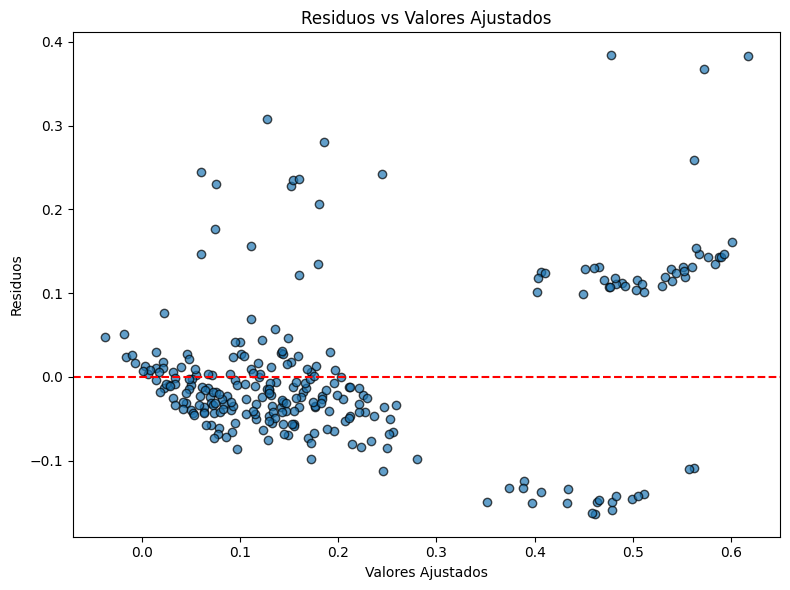

In [57]:

residuos = y_test - y_pred

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuos, edgecolors='k', alpha=0.7)

# Línea horizontal en y = 0 para mostrar los residuos
plt.axhline(0, color='red', linestyle='--')

# Etiquetas y título
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Ajustados')

# Mostrar gráfico
plt.tight_layout()
plt.show()


In [60]:

# Modelo OLS
ols_model = LinearRegression()
ols_model.fit(X_train_sel, y_train)
y_pred_ols = ols_model.predict(X_test_sel)

# Métricas para OLS
mse_ols = mean_squared_error(y_test, y_pred_ols)
r2_ols = r2_score(y_test, y_pred_ols)

print(f"Mean squared error (OLS): {mse_ols}")
print(f"Coefficient of determination (OLS): {r2_ols}")


Mean squared error (OLS): 0.009150574110332004
Coefficient of determination (OLS): 0.8045531086669286
